# Exercise 5.12 - Magnetic Field Produced by a Finite Straight Wire

## Problem Statement

Evaluate (5.25) for different grid sizes and compare the results with Ampere's Law. Derive a rule of thumb concerning how small the grid size must be in comparison with the distance from the wire, in order for the calculated field to be within 5 percent of the exact result.

(Eq. 5.25)

$$B \approx \sum \frac{\mu_0 I}{4 \pi} \frac{x \Delta z}{(z^2 + x^2) ^ {3/2}}$$

With $\Delta z$ the small length of wire to integrate along, and $x$ the magnitude of the distance from that point of wire to the point of interest.

## Evaluation of Ampere's Law

Given the Biot-Savart Law,

$$ B(\vec{r}) = \frac{\mu_0}{4 \pi} \int_C \frac{I \,d\vec{l} \times \vec{r}}{|r|^3}$$

the calculation of the magnetic field from a finite wire of length $2L$ at a point $p = (x, 0, 0)$ is found simply when using cylindrical coordinates. This simplifies to the expression

$$B = \frac{\mu_0 I}{4 \pi s} (\sin \theta_2 - \sin \theta_2)$$

where $\theta_i$ are the angles between the point $p$ and the endpoints of the wire of length $2L$. This result is further derived from the Griffiths book "Introduction to Electrodynamics, Third Edition" on pgs. 216-217.

## Computational Solution

### The Method

An adaptive step size $\Delta z$ method would greatly enhance the accuracy of this model, but this would not allow for controlled step sizes and would not allow for a rule to be determined on how small the grid size mst be depending on distance $x$ from the wire. So, I make use of a simple summation method where $\Delta z$ is held constant, the value of $z$ is iteratively added upon at each step, and $x$ is held constant as well. So,

$$\Delta B = \frac{\mu_0 I}{4 \pi} \frac{x \Delta z}{(z^2 + x^2)^{3/2}}$$

represents the small amount of magnetic field influence to be accounted for in a single step.

### Constants and Ranges

Here are the values I will be using for computation:

$$0.1 \leq x \leq 1.0$$
$$N_{\text{x pts}} = 100$$
$$L = 1 \, \text{m}$$
$$I = 1 \, \text{Amp}$$

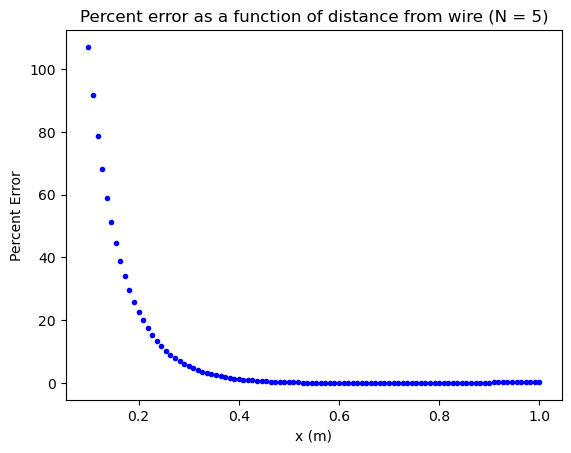

In [24]:
# Ampere's Law for a straight wire of finite length
import numpy as np
import matplotlib.pyplot as plt

class AmperesLaw:
    def __init__(self, I : float, L : float):
        """Solver for a finite length wire with current flowing and evaluated from the midpoint of the wire

        Args:
            I (float): current passing through the straight wire in Amps
            L (float): half the length of the wire in meters
        """
        # Constants of electrodynamics
        self.π = 3.14159265
        self.μ0 = 4 * self.π * 1e-7
        self.L = 2 * L
        self.I = I
    
    def BExact(self, _x : float):
        """Biot-Savart solution to the problem evaluated at point (x, 0, 0) from the wire (midpoint)

        Args:
            x (float): x value to evaluate the magnetic field from

        Returns:
            B: exact magnetic field, or theoretical measurement of B in Teslas
        """
        # Since the bound from the Biot-Savart result above are symmetric in this special case, I can simply double
        # the effective magnetic field from θ1 to 0.0, which is L / Sqrt[x^2 + L^2] = Opposite / Hypotenuse
        return self.μ0 * self.I / (2 * self.π * _x) * (self.L / (_x * _x + self.L * self.L) ** 0.5)
    
    def BNumeric(self, _x : float, _N : int):
        """Computes a numerical approximation to the magnetic field induced at a
        distance, x, from the midpoint of a straight finite current-carrying wire with N steps along the wire

        Args:
            _x (float): distance from midpoint of the wire
            _N (int): number of small steps to integrate along the wire

        Returns:
            B: magnetic field approximation in Teslas
        """
        _z = self.L
        _Δz = 2 * self.L / _N
        _B = 0.0
        
        for _ in range(_N):
            _ΔB = _x * _Δz / (_z * _z + _x * _x) ** 1.5
            _B += _ΔB
            _z -= _Δz
        
        return self.μ0 * self.I / (4 * self.π) * _B
    
    def CalculatedError(self, _BTheory : float, _BExperiment : float):
        """Calculated the error in computational results

        Args:
            _BTheory (float): the value of B as derived from the Biot-Savart Law, exactly
            _BExperiment (float): the value of B as discovered by other methods

        Returns:
            percent error: how wrong the experiment was compared to the predicted value
        """
        return abs(_BTheory - _BExperiment) / abs(_BTheory) * 100.0

L = 1.0
I = 1.0

finiteWire = AmperesLaw(I = I, L = L)

xVals = np.linspace(0.1, 1.0, 100)

N = 10

errors = []

for x in xVals:
    BExact = finiteWire.BExact(_x = x)
    BNumeric = finiteWire.BNumeric(_x = x, _N = N)
    errors.append(finiteWire.CalculatedError(_BTheory = BExact, _BExperiment = BNumeric))

plt.title('Percent error as a function of distance from wire (N = 10)')
plt.plot(xVals, errors, 'b.')
plt.xlabel('x (m)')
plt.ylabel('Percent Error')
plt.show()

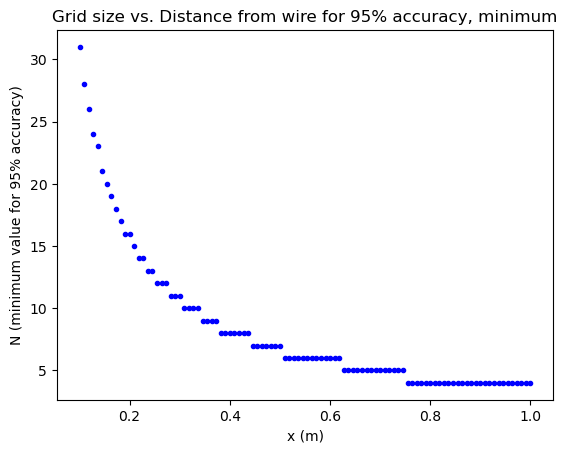

In [25]:
"""
Based on the graph above, it is obvious that the closer we evaluate to the wire, the less accuracy that can be provided
by the same step size. This is to be expected as with any sort of differential equation, not all steps should be the same
size. However, to get within 5 percent error every time, a good way to do this is with an iterative approach using the computer.

So, I will reprogram the loop in such a way that the sum will be re-evaluated by increasing N each time, until the sum is
within 5 percent of the theoretical value. To make this extra meaningful, I will keep track of the different N values required
to cause such convergence on the true value and plot them against the distances from the midpoint of the wire, x.
"""

ε = 5.0 # Error parameter, which is 5 percent
error = 100.0 # initial error to enforce while loop's proper behavior

Nlist = []

for x in xVals:
    # Reset the N value to 1 for each iteration so that N can be known for each value of x for best accuracy
    N = 1
    while error > ε:
        # Gets the values to compute the computational error given a value of N
        BExact = finiteWire.BExact(_x = x)
        BNumeric = finiteWire.BNumeric(_x = x, _N = N)
        error = finiteWire.CalculatedError(_BTheory = BExact, _BExperiment = BNumeric)
        
        # This will only happen if the loop has not yet been broken out of, since error is updated before N is added upon
        if error > ε:
            N += 1
        else:
            break
    
    # Reset the error to 100 percent and add the N value to the list
    error = 100.0
    Nlist.append(N)

plt.plot(xVals, Nlist, 'b.')
plt.xlabel('x (m)')
plt.ylabel('N (minimum value for 95% accuracy)')
plt.title('Grid size vs. Distance from wire for 95% accuracy, minimum')
plt.show()

This curve looks a lot like like an exponential function, where $N$ is a function of $x$

$$N(x) = \frac{\alpha}{\beta(x)}$$

where $\alpha$ is some constant and $\beta(x)$ is some function of $x$. I am approximating a $\frac{1}{x}$ form since $\lim_{x \rightarrow 0} = \infty$.

### Creating the Model - N(x)

Using the guessed function

$$N(x) = \frac{\alpha}{x}$$

as a basis for the modelled approximation, I'll make use of SciPy's builtin function 'curve_fit' to optimize my parameter $\alpha$ to the data.

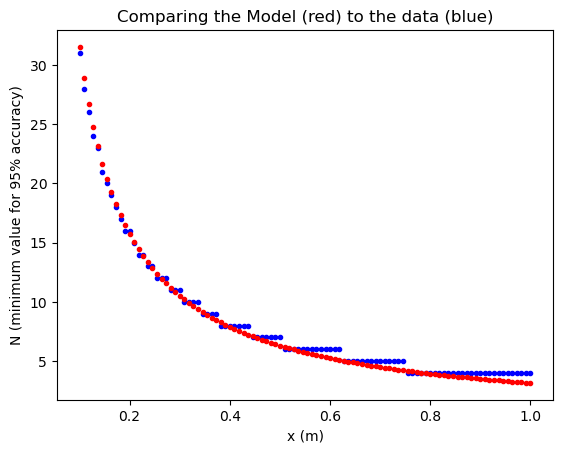

α : 3.154 m ^ -1


In [34]:
import scipy.optimize as optim

f = lambda _x, _α: _α / (_x)

α, _ = optim.curve_fit(f, xVals, Nlist)

plt.plot(xVals, Nlist, 'b.')
plt.xlabel('x (m)')
plt.ylabel('N (minimum value for 95% accuracy)')
plt.title('Comparing the Model (red) to the data (blue)')
plt.plot(xVals, f(_x = xVals, _α = α), 'r.')
plt.show()

print(f"α : {α.item():.3f} m ^ -1")

## Conclusion

As shown, my model describes that the grid size depends inversely on the distance away from the wire $x$. The function $N(x)$ has been approximated to

$$N(x) \approx \frac{3.154}{x}$$

where the output should be rounded up to the next nearest integer in all cases to ensure the desired accuracy.